# Introduction

In this notebook, we will look at detecting anomalies in multivariate time series data.

In a real-world scenario, we don't usually know which observations are anomalous in the training set (i.e. we don't have labels). However in this dataset, the class labels are provided, which allows us to implement both supervised and unsupervised learning approaches. 

Obviously, we expect the supervised learning approaches to perform better. In practice, when faced with the challenges of detecting failures for heavy-asset equipments, we likely do not have access to labeled failures or have access to such a limited  number of labels that it is impossible to use supervised approaches. 

## Dataset

We are going to detect anomalies in time series data coming from turbofan engines. The dataset was extracted from the [Turbofan engine degradation simulation data set](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan) (dataset ID: "FD001"). 

Reference: Saxena, A., Goebel, K., Simon, D. and Eklund, N., 2008, October. Damage propagation modeling for aircraft engine run-to-failure simulation. In Prognostics and Health Management, 2008. PHM 2008. International Conference on (pp. 1-9). IEEE.

The dataset consists of multivariate time series produced by sensors placed on 100 turbofan engines. The engine is operating normally at the start of each time series, and develops a fault at some point in time during the series. In the training set, the fault grows in magnitude until system failure. In the validation set, the time series ends some time prior to system failure. 

An equipment develops a fault at some point which lasts until the end of the series, corresponding to a system failure. Based on that, a label of anomaly (coded as 1) is assigned to samples that fall within a time window of 30 cycles prior to the system failure. All other samples are considered normal, coded as 0. 

The columns are:
- id: Engine ID
- cycle: elapsed time since the beginning
- RUL (Remaining Useful Life): remaining time before failure
- setting1 to setting3: operational setting
- s1 to s21: sensor measurement
- label: 0 for normal and 1 for anomalies.

The goal is to detect which time series is an anomaly in the validation set. The model performance will be graded using the [f1-score](https://en.wikipedia.org/wiki/F1_score). 

<img src="images/data_overview.png" width=100% />

# Exploratory data analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import keras.backend as K
import joblib

from pathlib import Path
from funcsigs import signature
from sklearn.preprocessing import RobustScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, auc

from keras.models import load_model
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


Let's import the data.

In [2]:
train_df = pd.read_csv('data/train.csv')
validation_df = pd.read_csv('data/validation.csv')
train_df.shape, validation_df.shape

((20631, 28), (5245, 28))

In [3]:
train_df.head(5)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


The proportion between abnormal and normal observations is: 

In [4]:
train_df['label'].value_counts()[1] / len(train_df['label'])

0.15025931850128446

Check for missing values.

In [5]:
print("Training:", train_df.isnull().values.any())
print("Test:", validation_df.isnull().values.any())

Training: False
Test: False


Let us take a look at some basic statistics of each of the column in each set: 

In [6]:
train_df.groupby('id').describe().head()

cycle                                                     setting1  \
    count   mean        std  min    25%    50%     75%    max    count   
id                                                                       
1   192.0   96.5  55.569776  1.0  48.75   96.5  144.25  192.0    192.0   
2   287.0  144.0  82.993976  1.0  72.50  144.0  215.50  287.0    287.0   
3   179.0   90.0  51.816986  1.0  45.50   90.0  134.50  179.0    179.0   
4   189.0   95.0  54.703748  1.0  48.00   95.0  142.00  189.0    189.0   
5   269.0  135.0  77.797815  1.0  68.00  135.0  202.00  269.0    269.0   

              ...     RUL         label                                     \
        mean  ...     75%    max  count      mean       std  min  25%  50%   
id            ...                                                            
1  -0.000189  ...  143.25  191.0  192.0  0.161458  0.368915  0.0  0.0  0.0   
2   0.000051  ...  214.50  286.0  287.0  0.108014  0.310940  0.0  0.0  0.0   
3   0.000137  ...  133.50  178.0  179.0  0.173184  0.379468  0.0  0.0  0.0   
4   0.000150  ...  141.00  188.0  189.0  0.164021  0.371278  0.0  0.0  0.0   
5   0.000136  ...  201.00  268.0  269.0  0.115242  0.319909  0.0  0.0  0.0   

              
    75%  max  
id            
1   0.0  1.0  
2   0.0  1.0  
3   0.0  1.0  
4   0.0  1.0  
5   0.0  1.0  

[5 rows x 216 columns]

In [7]:
validation_df.groupby('id').describe().head()

cycle                                                   setting1  \
    count  mean        std  min    25%   50%     75%    max    count   
id                                                                     
4   106.0  53.5  30.743563  1.0  27.25  53.5   79.75  106.0    106.0   
6   105.0  53.0  30.454885  1.0  27.00  53.0   79.00  105.0    105.0   
8   166.0  83.5  48.064193  1.0  42.25  83.5  124.75  166.0    166.0   
11   83.0  42.0  24.103942  1.0  21.50  42.0   62.50   83.0     83.0   
15   76.0  38.5  22.083176  1.0  19.75  38.5   57.25   76.0     76.0   

              ...     RUL         label                                     
        mean  ...     75%    max  count mean  std  min  25%  50%  75%  max  
id            ...                                                           
4  -0.000184  ...  160.75  187.0  106.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
6   0.000249  ...  171.00  197.0  105.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
8   0.000201  ...  218.75  260.0  166.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
11  0.000306  ...  158.50  179.0   83.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
15  0.000084  ...  139.25  158.0   76.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 216 columns]

/home/pierre/bin/anaconda3/envs/time_series/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


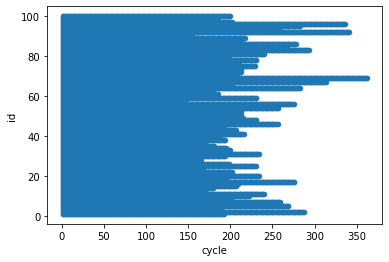

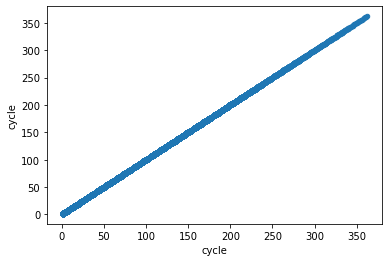

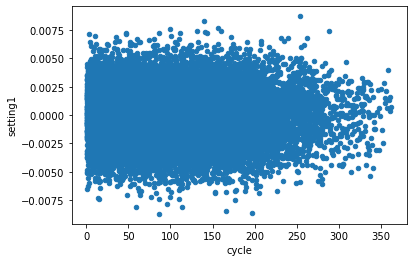

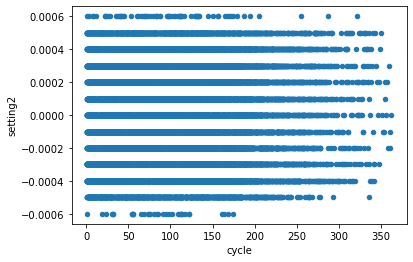

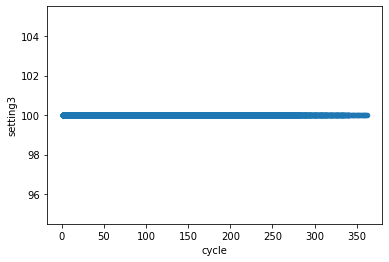

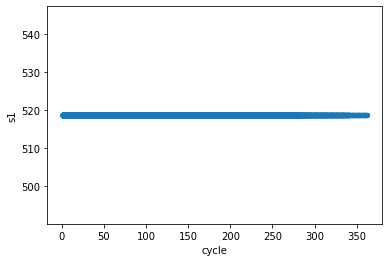

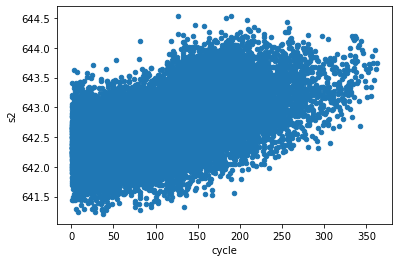

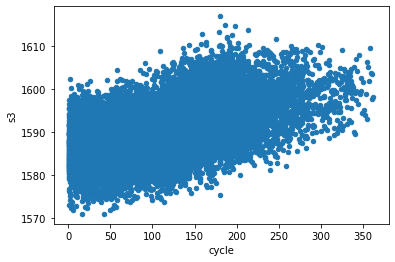

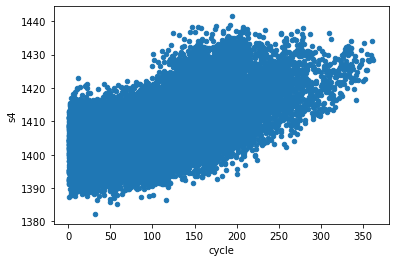

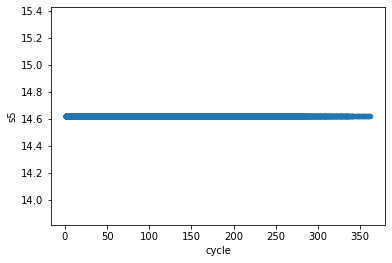

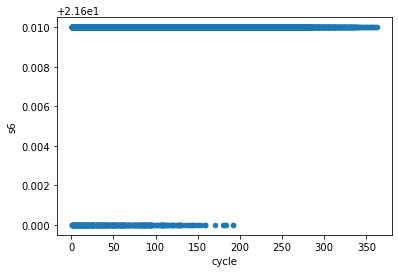

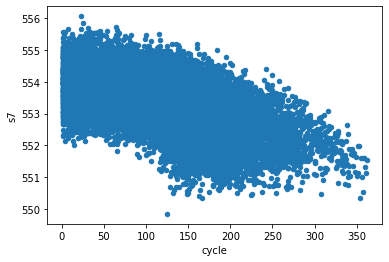

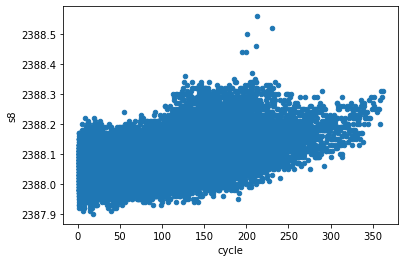

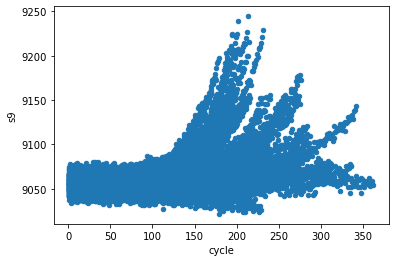

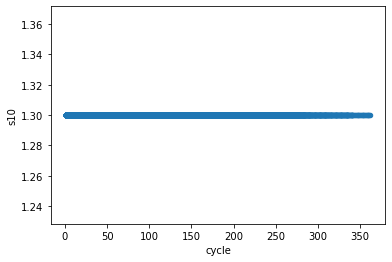

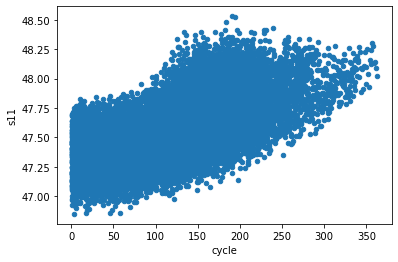

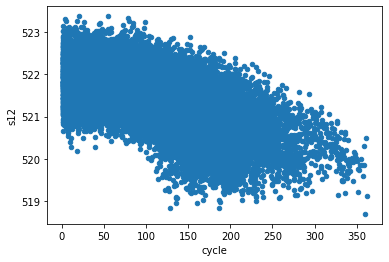

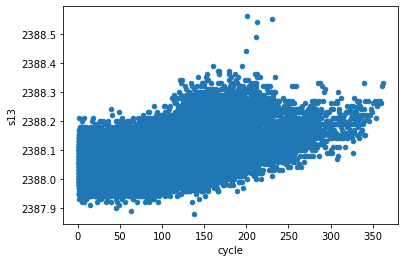

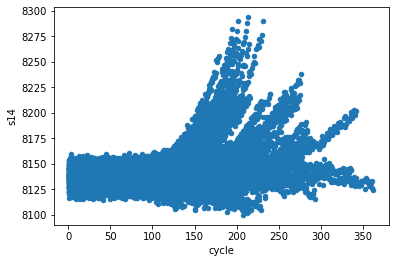

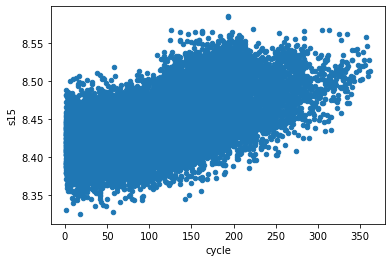

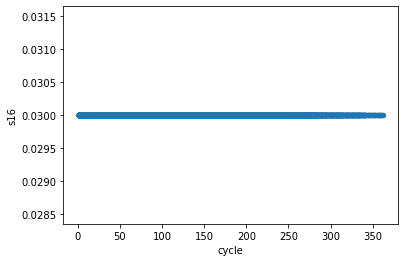

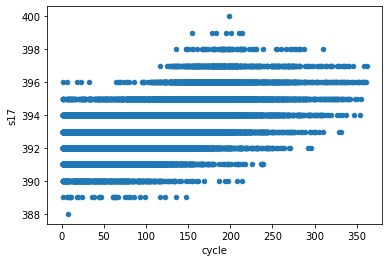

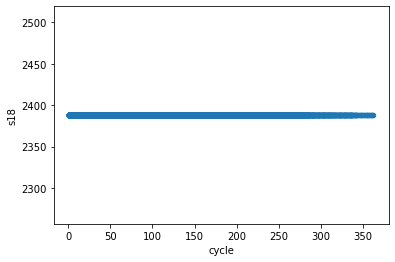

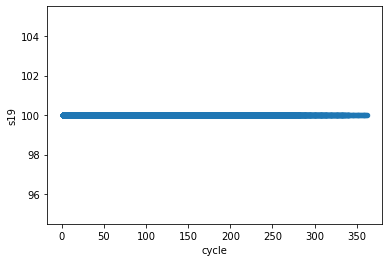

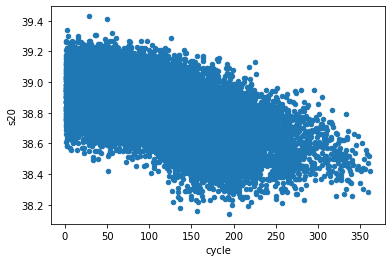

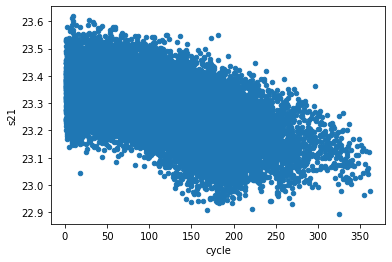

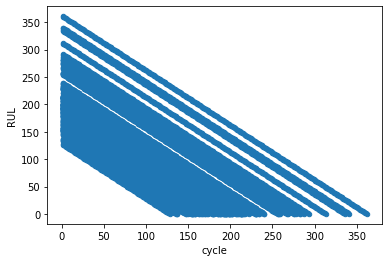

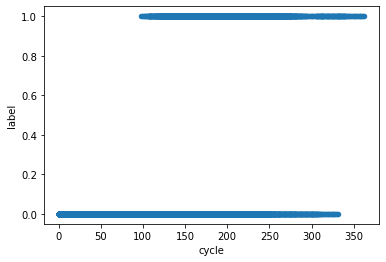

In [8]:
for col in train_df.columns:
    train_df.plot(kind='scatter', x='cycle',y=col)

Some observations: 

- `setting3`, `s1`, `s5`, `s10`, `s16`, `s18` and `s19` are constant, both in the training and in the validation sets, we may disregard these variables from the analyses.
- The statistics on the number of cycles are not relevant, as we should only look at the statistics for the maximum number of cycles for each engine. However, the mean and median number of cycles for the training set are larger than for the validation set, confirms the fact that in the training set, the engines run until system failure, wheras in the validation set, the time series ends prior to system failure.

In [9]:
train_df = train_df.drop(['setting3', 's1', 's5', 's10', 's16', 's18', 's19'], axis=1)
validation_df = validation_df.drop(['setting3', 's1', 's5', 's10', 's16', 's18', 's19'], axis=1)

Split X and y data and create feature list.

In [10]:
features = ['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 
            's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']

X_train, y_train = train_df[features], train_df['label']
X_validation, y_validation = validation_df[features],  validation_df['label']

Plot the sensors as a function of the Remaining Useful Life (RUL) for the first 10 engines.

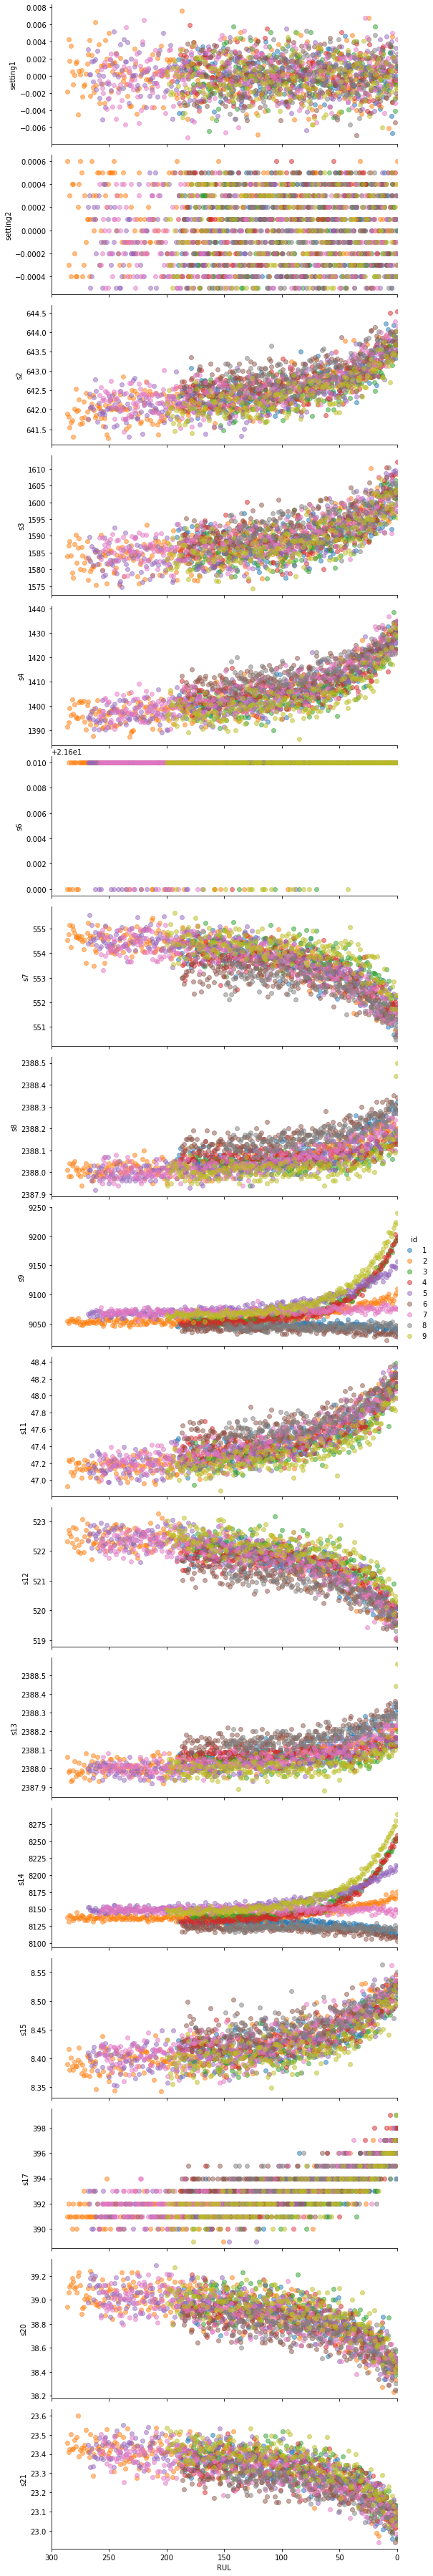

In [11]:
g = sns.PairGrid(data=train_df.query('id < 10') ,
                 x_vars=['RUL'],
                 y_vars=features,
                 hue="id", height=3, aspect=2.5)
g = g.map(plt.scatter, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

# Unsupervised learning

In this section, we will build anomaly detection models using unsupervised approaches, i.e. the class labels are not used during this process. 

## Preprocessing

Normalize the features so that they are in the same range. 

In [12]:
scaler = RobustScaler()

# fit the scaler using the training data
scaler.fit(X_train)

# apply the scaler to both the training and validation sets
X_train_norm = scaler.transform(X_train)
X_validation_norm = scaler.transform(X_validation)

print(X_train_norm.shape, X_validation_norm.shape)

(20631, 17) (5245, 17)


## Model training

In [13]:
models_unsupervised = {
    'OneClassSVM': OneClassSVM(nu=0.1, kernel="rbf", gamma='auto'),
    'RobustCovariance': EllipticEnvelope(contamination=0.05),
    'IsolationForest': IsolationForest(),
    'LocalOutlierFactor': LocalOutlierFactor(novelty=True)
}

Now, fit the models using the training data: 

In [14]:
for model_name, model in models_unsupervised.items():
    print("Fitting ", model_name)
    models_unsupervised[model_name] = model.fit(X_train_norm)

Fitting  OneClassSVM
Fitting  RobustCovariance
Fitting  IsolationForest
Fitting  LocalOutlierFactor


# Model evaluation metrics

Let's apply our trained models to the validation set and calculate the model performance using accuracy and area under the ROC curve (AUC): 

In [15]:
def performance(yhat, y, score=None): 
    """calculate various model evaluation metrics
    Args: 
        yhat (binary): predicted label
        y (binay): true label
        score (float): anomaly score
    Returns: 
        dictionary containing different evaluation metrics
    """
    performance = {}
    performance['accuracy'] = accuracy_score(y, yhat)
    performance['precision'] = precision_score(y, yhat)
    performance['recall'] = recall_score(y, yhat)
    performance['F1'] = f1_score(y, yhat)
    performance['yhat'] = yhat
    
    if score is not None: 
        FP, TP, _ = roc_curve(y, score)
        performance['FP_TP'] = (FP, TP)
        performance['AUC'] = auc(FP, TP)
        performance['anomaly_score'] = score
    return performance

In [16]:
def plot_confmat(yhat, y, title):
    """
    Plot the confusion matrix
    Args: 
        yhat (binary): predicted label
        y (binay): true label
    """
    cm = confusion_matrix(y, yhat)
    ConfusionMatrixDisplay(cm).plot(values_format="d")
    plt.title(title);
    

def plot_ROC(FP, TP, AUC, model_name):
    RocCurveDisplay(fpr=FP, tpr=TP, roc_auc=AUC, estimator_name=model_name).plot()
    plt.title(model_name)
    
    
def plot_PRC(y_score, model_name):
    prec, rec, _ = precision_recall_curve(y_validation, y_score)
    PrecisionRecallDisplay(precision=prec, recall=rec, average_precision=np.mean(prec), estimator_name=model_name).plot()
    plt.title(model_name)
    plt.legend(loc="upper right")

Use the trained models to make predictions on the validations set. 

In [17]:
results_unsupervised = {}

for model_name, model in models_unsupervised.items():
    pred = model.predict(X_validation_norm)
    yhat = np.where(pred == -1, 1, 0)                             # why this transform?
    anomaly_score = - model.decision_function(X_validation_norm)  # why negative?
    perf = performance(yhat, y_validation, score=anomaly_score)
    results_unsupervised[model_name] = perf
    
    print('{}: accuracy: {:.2f}, AUC: {:.2f}, precision: {:.2f}, recall: {:.2f}, F1: {:.2f}'
          .format(model_name, perf['accuracy'], perf['AUC'], perf['precision'], perf['recall'], perf['F1']))

OneClassSVM: accuracy: 0.92, AUC: 0.65, precision: 0.05, recall: 0.11, F1: 0.07
RobustCovariance: accuracy: 0.98, AUC: 0.69, precision: 0.50, recall: 0.02, F1: 0.04
IsolationForest: accuracy: 0.95, AUC: 0.86, precision: 0.15, recall: 0.21, F1: 0.17
LocalOutlierFactor: accuracy: 0.98, AUC: 0.45, precision: 0.00, recall: 0.00, F1: 0.00


/home/pierre/bin/anaconda3/envs/time_series/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy can be misleading particularly in the case of highy imbalanced data. In which cases, other metrics such as precision, recall and f1_score should be used. 

To gain more insights on the performance of the model on each class, let us take a look at the confusion matrix.

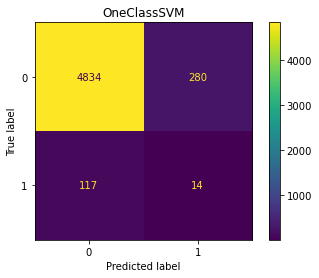

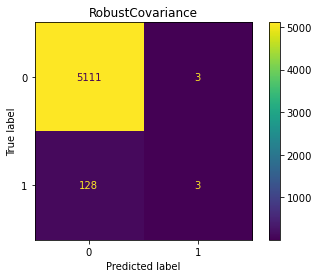

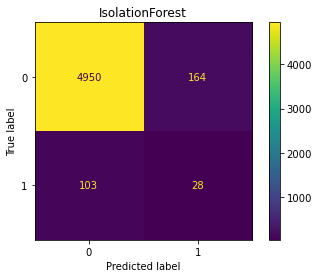

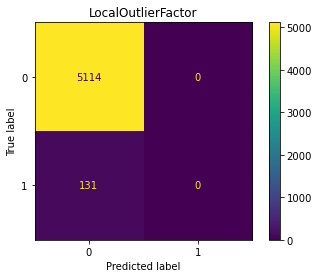

In [18]:
for model_name, model in models_unsupervised.items():
    yhat = results_unsupervised[model_name]['yhat']
    
    plot_confmat(yhat, y_validation, model_name)

We can see that some models produce a lot of false negatives and false positives. Another interesting plots are the ROC and PRC curves.

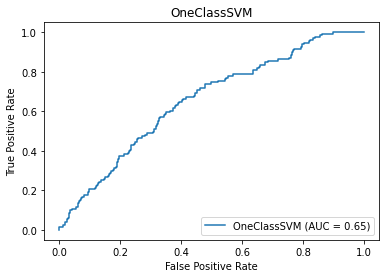

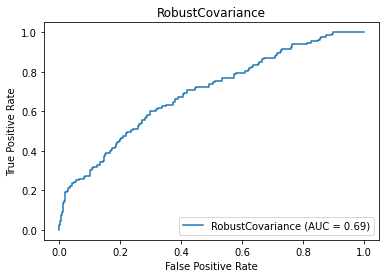

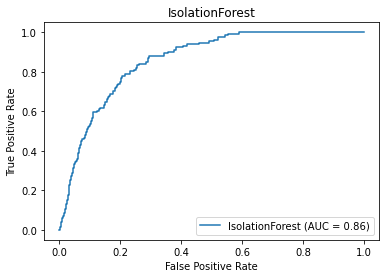

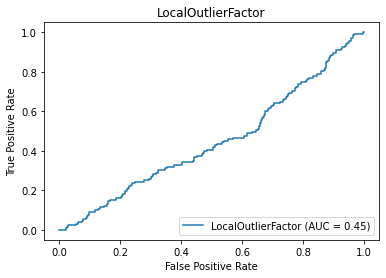

In [19]:
for model_name, model in models_unsupervised.items():
    FP, TP = results_unsupervised[model_name]['FP_TP']
    AUC = results_unsupervised[model_name]['AUC']
    
    plot_ROC(FP, TP, AUC, model_name)

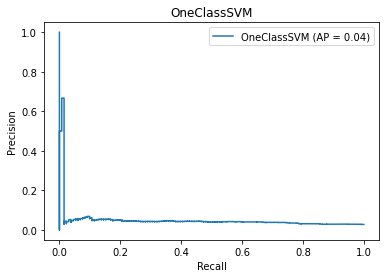

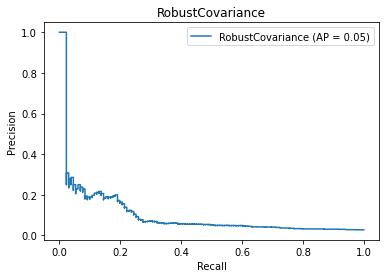

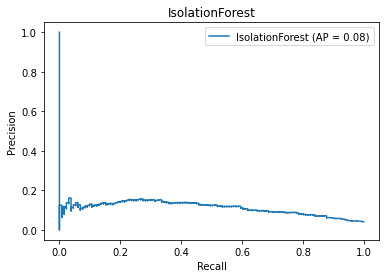

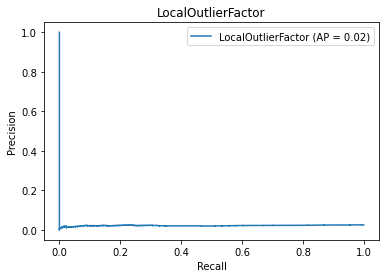

In [20]:
for model_name, model in models_unsupervised.items():
    y_score = results_unsupervised[model_name]['anomaly_score']
    
    plot_PRC(y_score, model_name)

Isolation Forest performs the best (but it's not great...)

# Supervised learning

We will now use the labels and use supervised learning to improve the performance.

Let us use the default values of the hyperparameters. Potentially, an improved model can be built by tuning the hyperparameters of an algorithm using cross-validation on the training data. 

In [21]:
lr = LogisticRegression()
rfc = RandomForestClassifier()
knc = KNeighborsClassifier()
svc = SVC(gamma='auto', probability=True)

models_supervised = {
    'LogisticRegression': lr,
    'RandomForestClassifier':rfc,
    'KNeighborsClassifier': knc,
    'SVC': svc
}

Now, fit the models using the training data: 

In [22]:
for model_name, model in models_supervised.items():
    print("Fitting ", model_name)
    models_supervised[model_name] = model.fit(X_train_norm, y_train)

Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  KNeighborsClassifier
Fitting  SVC


Apply the trained model on the validation data and calculate the performance. Note that we will make use of the `performance` function introduced in the "Unsupervised learning" section. 

In [23]:
results_supervised = {}
for model_name, model in models_supervised.items():
    # predict
    yhat = model.predict(X_validation_norm)
    anomaly_score = model.predict_proba(X_validation_norm)[:, 1]
    perf = performance(yhat, y_validation, score=anomaly_score)
    results_supervised[model_name] = perf

    print('{}: accuracy = {:.2f}, AUC = {:.2f}, precision = {:.2f}, recall = {:.2f}, F1 = {:.2f}'
          .format(model_name, perf['accuracy'], perf['AUC'], perf['precision'], perf['recall'], perf['F1']))

LogisticRegression: accuracy = 0.99, AUC = 0.99, precision = 0.86, recall = 0.50, F1 = 0.63
RandomForestClassifier: accuracy = 0.98, AUC = 0.98, precision = 0.89, recall = 0.45, F1 = 0.60
KNeighborsClassifier: accuracy = 0.98, AUC = 0.86, precision = 0.83, recall = 0.47, F1 = 0.60
SVC: accuracy = 0.98, AUC = 0.82, precision = 0.90, recall = 0.44, F1 = 0.59


The F1 score has improved significantly. Let's check the plots.

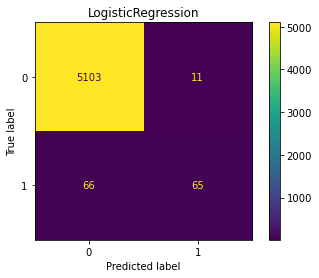

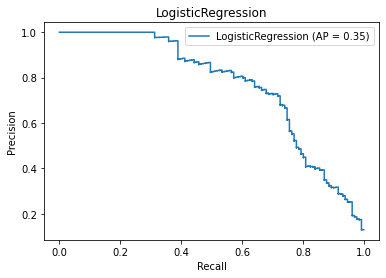

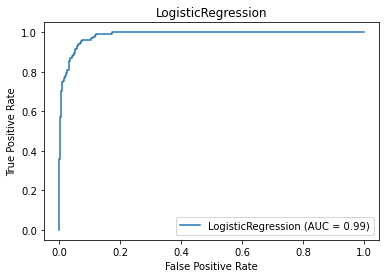

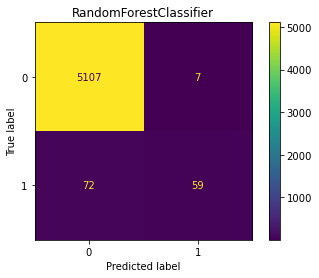

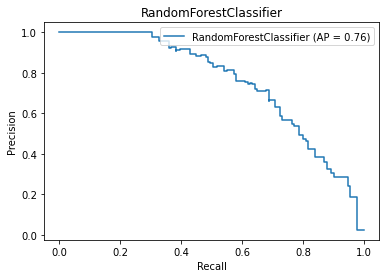

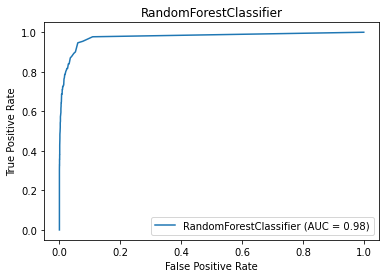

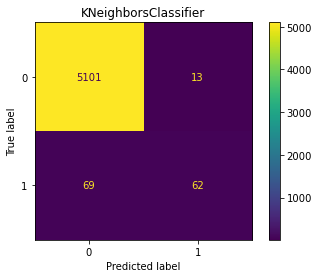

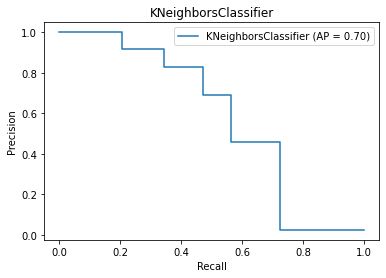

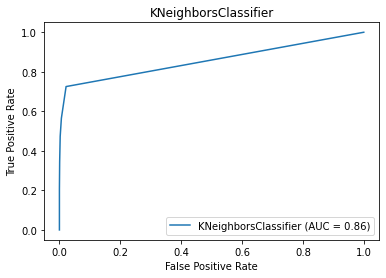

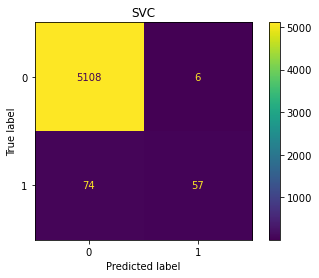

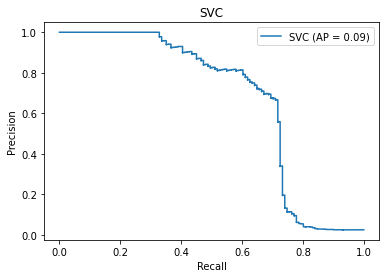

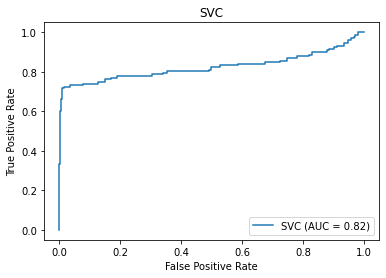

In [24]:
for model_name, model in models_supervised.items():
    yhat = results_supervised[model_name]['yhat']
    y_score = results_supervised[model_name]['anomaly_score']
    FP, TP = results_supervised[model_name]['FP_TP']
    AUC = results_supervised[model_name]['AUC']
    
    plot_confmat(yhat, y_validation, model_name)
    plot_PRC(y_score, model_name)
    plot_ROC(FP, TP, AUC, model_name)

# Deep learning-based approaches

Here we will experiment with the **autoencoder** as an unsupervised deep learning-based approach for anomaly detection. 

The autoencoder model aims to derive a data driven representation of the identity function. Given that by far the majority of the training data are of class normal we might expect this identity mapping to perform well for that class and less well for the class where we have far fewer training examples. It follows that if we calculate the performance of the mapping using, e.g., mean squared error, and determine a large quantile (e.g. 95%) of the performance we might start to identify the anomalies. 


First we construct the model. We will use a shallow autoencoder with no hyperparameter optimization (the setup of the hidden layer is fairly arbitrary and there may be significant room for improvement). As the model will have number of parameters comparable to a significant fraction of the training dataset we feel it's necessary to implement regularization to avoid overfitting; we use simple L1 but it might be interesting to see if dropout can improve performance.

In [25]:
K.clear_session()

# input layer
input_layer = Input(shape=(len(features), ))

# encoding layer with arbitrary hyperparameters and L1 regularization
encoder = Dense(
    20, 
    activation="relu",
    activity_regularizer=regularizers.l1(10e-5)
)(input_layer)

# decoding layer
decoder = Dense(len(features), activation='relu')(encoder)

# book the model and summarize 
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 17)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                360       
_________________________________________________________________
dense_2 (Dense)              (None, 17)                357       
Total params: 717
Trainable params: 717
Non-trainable params: 0
_________________________________________________________________


Next configure and train the model, we will save the model for later use, note this introduces a hidden dependency to h5py:

In [26]:
# require model be saved and logged
checkpointer = ModelCheckpoint(filepath="saved_models/model.h5", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./tensorboard_logs', histogram_freq=0, write_graph=True, write_images=True)

# compile the model for training
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

n_epochs = 100
batch_size = 64

# train
history = (
    autoencoder.fit(
        X_train_norm, X_train_norm,
        epochs=n_epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=0, #set to 1 to monitor the fitting progress
        validation_data=[X_validation_norm, X_validation_norm],
        callbacks=[checkpointer, tensorboard]
    ).history
)

Now we have a trained model, let's plot the loss evolution as a function of training input:

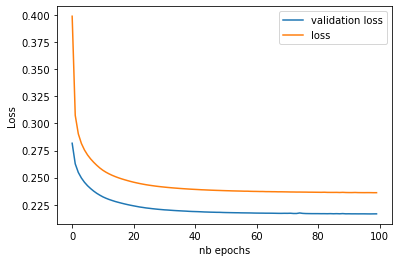

In [27]:
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.xlabel('nb epochs')
plt.ylabel('Loss')
plt.legend(['validation loss','loss']);

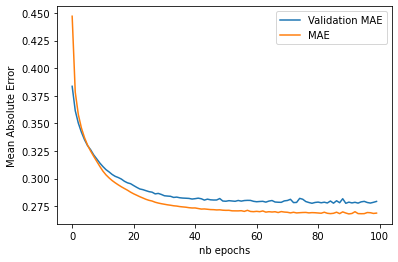

In [28]:
plt.plot(history['val_mae'])
plt.plot(history['mae'])
plt.xlabel('nb epochs')
plt.ylabel('Mean Absolute Error')
plt.legend(['Validation MAE','MAE']);

In [29]:
%load_ext tensorboard
%tensorboard --logdir tensorboard_logs/

Reusing TensorBoard on port 6006 (pid 23495), started 4:01:01 ago. (Use '!kill 23495' to kill it.)

We can see that there is a considerable gap between the validation and training datasets, which indicates a potential for improving the model. Note however that the loss on the validation set is lower than that on the training set, which may appear to be counter-intuitive. 

**Exercise**: compare the class proportion (anomaly vs. normal) between the training and validation sets to find an explanation from a data-characteristics point of view to the difference in loss. 

Now we want to use the train data to determine the 95% threshold which assigns an anomaly and see how that impact the performance of anomaly detection on the validation data:

In [30]:
K.clear_session()

trained_model = load_model('saved_models/model.h5')
train_predicted = trained_model.predict(X_train_norm)
train_mse = mean_squared_error(train_predicted.T, X_train_norm.T, multioutput='raw_values')
thresh_train = np.percentile(train_mse, 95)
print(thresh_train)

0.5955389412780298


In [31]:
# propagate the scaled validation data through prediction workflow
val_predicted = trained_model.predict(X_validation_norm)
val_mse = mean_squared_error(val_predicted.T, X_validation_norm.T, multioutput='raw_values')
yhat = [0 if imse < thresh_train else 1 for imse in val_mse]
perf = performance(yhat, y_validation)

# Why is it not possible to calculate an anomaly score in this case?
#anomaly_score = trained_model.predict_proba(X_validation_norm)[:, 1]
#anomaly_score = - trained_model.decision_function(X_validation_norm) 

print('{}: accuracy = {:.2f}, precision = {:.2f}, recall = {:.2f}, F1 = {:.2f}'
          .format("Autoencoder", perf['accuracy'], perf['precision'], perf['recall'], perf['F1']))

Autoencoder: accuracy = 0.96, precision = 0.08, recall = 0.05, F1 = 0.06


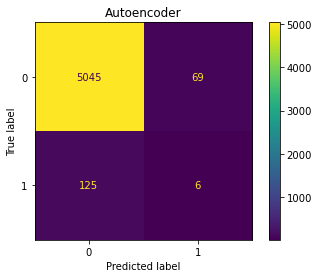

In [32]:
plot_confmat(yhat, y_validation, "Autoencoder")

**Exercise**: to avoid overfitting while tuning the model, split the original training set into two subsets: one used for training and the other one used for validation. The original validation would be used as an independent test set to evaluate the final model. Repeat the above analyses. Experiment with different quantile thresholds and network architectures and observe how the changes affect the performance. 

# Model persistence

Once a model is successfuly built with satisfying performance as quantified by an evaluation metric, it should be persisted for use in production to perform anomaly detection on unseen production data. 


A model can be persisted/saved as follows: 

In [33]:
model_name = 'RandomForestClassifier'
model = models_supervised[model_name]

joblib.dump(model, 'saved_models/{}.model'.format(model_name))

['saved_models/RandomForestClassifier.model']

Note that any preprocessing steps performed prior to model training, such as feature scaling, should also be persisted to be used on the production data. 

In [34]:
joblib.dump(scaler, 'saved_models/scaler.model')

['saved_models/scaler.model']

# Model comparison

In this section, we will compare the performance of all models that have been built so far: 

In [35]:
results = {**results_supervised, **results_unsupervised}

metrics_ = ['accuracy', 'AUC', 'precision', 'recall', 'F1']

df = pd.DataFrame()
for model, result in results.items():
    df = df.append(
        pd.DataFrame(
            data={ key: result[key] for key in metrics_ },
            index=[model]
        )
    )
print(df)

                        accuracy       AUC  precision    recall        F1
LogisticRegression      0.985319  0.985519   0.855263  0.496183  0.628019
RandomForestClassifier  0.984938  0.976073   0.893939  0.450382  0.598985
KNeighborsClassifier    0.984366  0.856632   0.826667  0.473282  0.601942
SVC                     0.984747  0.824063   0.904762  0.435115  0.587629
OneClassSVM             0.924309  0.652634   0.047619  0.106870  0.065882
RobustCovariance        0.975024  0.694067   0.500000  0.022901  0.043796
IsolationForest         0.949094  0.857929   0.145833  0.213740  0.173375
LocalOutlierFactor      0.975024  0.447322   0.000000  0.000000  0.000000


Compare the ROC curve of an unsupervised and a supervised model. 

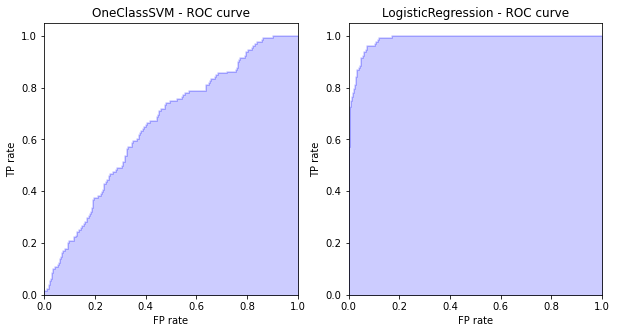

In [36]:
model_names = ['OneClassSVM', 'LogisticRegression']
results_ = [results[model_name] for model_name in model_names]

step_kwargs = (
    {'step': 'post'}
    if 'step' in signature(plt.fill_between).parameters
    else {}
)

_, ax = plt.subplots(1, len(model_names), figsize=(10,5))

for n, result in enumerate(results_):
    FP, TP = result['FP_TP']
    ax[n].step(FP, TP, color='b', alpha=0.2, where='post')
    ax[n].fill_between(FP, TP, alpha=0.2, color='b', **step_kwargs)
    ax[n].set_xlabel('FP rate')
    ax[n].set_ylabel('TP rate')
    ax[n].set_ylim([0.0, 1.05])
    ax[n].set_xlim([0.0, 1.0])
    ax[n].set_title('{} - ROC curve'.format(model_names[n]))

The above plot clearly shows a significant difference in performance between supervised and unsupervised learning. 

# Challenge

Build your best model given the training and validation data and output your model, as well as any preprocessing steps needed, for the deployment step. 

Potential avenues for performance improvement: 
- Explore the use of other anomaly detection approaches (ref. [pyod](https://pyod.readthedocs.io/en/latest/), [scikit-learn](https://scikit-learn.org/stable/modules/outlier_detection.html)).
- Feature reduction using techniques such as Principal Component Analysis (PCA) or feature selection. 
- Resolve data imbalanced issue using data imputation.
- Model hyperparameter tuning using cross-validation. 


# Conclusions

Through the analyses presented in this notebook, we have learned about: 
- End-to-end iterative model development workflow applied to anomaly detection using data of a physical equipment, consisting of: 
    - Exploratory data analysis,
    - Model training,
    - Model persistence for deployment. 
- A wide variety of anomaly detection approaches (supervised, unsupervised). 
- Different metrics that can be used for quantifying the performance of an anomaly detection model. 